In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Regression models

First let's load in the data:

In [2]:
bikeshare = pd.read_csv('../EDA/bikeshare_train_data_pcwsdetrend.csv', parse_dates=['Date'],index_col=['Date'])
bikeshare_test = pd.read_csv('../EDA/bikeshare_test_data_pcwsdetrend.csv', parse_dates=['Date'],index_col=['Date'])

In [3]:
bikeshare.sample(5)

,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,snow_on_ground,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,adj_num_trips
Date,,,,,,,,,,,,,,,,,,,,
2023-03-12,700.183333,2.4,9.9,6.2,7.5,11.8,0.0,4.9,0.0,4.9,0.0,16.0,9.139106,9.496097,9.317601,4001529.66,1802161.0,407.0,1409,1204.140960
2017-01-21,535.133333,4.2,10.5,7.4,6.3,10.6,0.0,1.6,0.0,1.6,0.0,0.0,10.570275,11.476575,11.023425,1633394.00,624089.0,0.0,619,1966.111629
2022-02-03,571.150000,1.8,5.9,3.9,4.1,14.1,0.0,7.3,0.0,7.3,0.0,0.0,7.120000,8.156667,7.638333,1310289.00,522130.0,0.0,600,1111.917342
2019-08-15,864.233333,14.2,23.9,19.1,9.7,0.0,1.1,0.0,0.0,0.0,0.0,1.0,26.139579,26.264054,26.201816,13883108.66,6009888.0,0.0,5230,5719.952047
2021-06-22,974.266667,14.8,22.9,18.9,8.1,0.0,0.9,0.0,0.0,0.0,0.0,4.0,27.308814,27.329106,27.318960,8934273.67,5799286.0,0.0,3154,4068.881179


Recall that the features are defined as:

- ``day_length``: The number of minutes from sunrise to sunset for the given day
- ``min_temp``: The daily minimum temperature (deg C)
- ``max_temp``: The daily maximum temperature (deg C)
- ``mean_temp``: The mean temperature of the day (deg C)
- ``temp_diff``: The difference between the daily minimum and maximum temperatures (deg C)
- ``hdd``: The "Heating Degree Days" of the day, the number of degrees C that the daily average temperature is below 18 degrees C (0 if the daily average temperature is above 18 degrees C)
- ``cdd``: The "Cooling Degree Days" of the day, the number of degrees C that the daily average temperature is above 18 degrees C (0 if the daily average temperature is below 18 degrees C)
- ``rain``: The amount of rain that occurred that day (mm)
- ``snow``: The amount of snow that occurred that day (cm)
- ``total_precip``: The total amount of rain and snow that occurred that day (mm) (Note: the standard conversion of snow-to-rain amount is a factor of ten, so 1cm of snow is equivalent to 1mm of rain; therefore, this column is exactly the sum of ``rain`` and ``snow``)
- ``snow_on_ground``: The amount of snow observed on the ground during the day (cm)
- ``max_gust``: The difference between the speed of the observed maximum gust of wind (in km/hr) and 31 km/hr (0 if the maximum observed gust of wind is at or below 31 km/hr)
- ``mean_dep_temp``: The mean departure temperature of all bike rides taken that day (deg C)
- ``mean_ret_temp``: The mean return temperature of all bike rides taken that day (deg C)
- ``total_dist``: The total distance covered by all bike rides taken that day (m)
- ``total_duration``: The total time spent on bikes that day (sec)
- ``ebike_trips``: The number of bike rides taken on electric bikes that day
- ``num_trips`` The total number of bike rides taken that day, regardless of bicycle type
- In the notebook ``EDA.ipynb`` we added another column, ``adj_num_trips``, that are the number of trips with a certain baseline bikeshare demand removed. Depending on the file loaded in above, ``adj_num_trips`` is some adjusted number of bike rides for a particular de-trending.

We aim to predict this adjusted number of trips, and then later convert these into actual predicted ``num_trips``.

In ``EDA.ipynb`` we used correlation matrices, plots, and lasso regression to perform some feature selection and handle some collinearity issues between columns. As such the features we will focus on in this notebook are
- ``day_length``,
- ``max_temp``,
- ``temp_diff``,
- ``total_precip``,
- ``snow_on_ground``, and
- ``max_gust``.

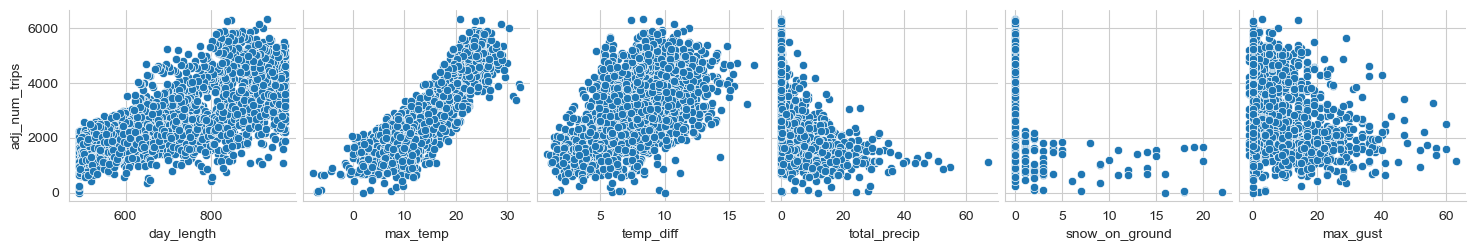

In [4]:
features = ['day_length','max_temp','temp_diff','total_precip','snow_on_ground','max_gust']
##Target variable name, this should be a column of the bikeshare-weather data csv that has a version of detrending applied to it
target = 'adj_num_trips'
sns.pairplot(data=bikeshare,
             x_vars=features,
            y_vars=[target])

plt.show()

Some initial thoughts:
- ``max_temp`` probably depends on ``day_length`` in some way so we should probably include an interaction term for these two features,
- Much of ``snow_on_ground`` is zero (and when nonzero has a pretty "small" distribution of values) so including or excluding this term in a model likely won't affect performance much, and
- ``max_gust`` and ``temp_diff`` look too scattered that it's possible they don't make it into the final model.

In any case, we only have six features under consideration. We can perform best subsets selection on these six features and then if some of the higher-performing subsets include ``day_length`` and ``max_temp`` we can compare those models' performances to one including an interaction term (we could do this in the other order--i.e., including the interaction, doing best subsets selection, then throwing away models that include the interaction term but not both the others, but our way has a shorter runtime).

In [5]:
# This returns the power set of a set minus the empty set. (Copied from a lecture notebook from this bootcamp)
# Credit to Erdős alumni Nadir Hajouji for greatly simplifying this function!

def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [7]:
n_splits = 5
kfold = KFold(n_splits,
              shuffle=True,
              random_state=604)

In [8]:
scaler = StandardScaler().set_output(transform='pandas')
bikeshare_scaled = scaler.fit_transform(bikeshare[features])
bikeshare_scaled[target] = bikeshare[target]

Before we look at best subsets let us look at just the mean ``adj_num_trips`` and its RMSE for a baseline to compare to; at this stage our only comparison is the base demand trend from ``EDA.ipynb``.

In [9]:
avg_num_trips = bikeshare[target].mean()
baseline_rmse = np.sqrt(mean_squared_error(bikeshare[target], np.ones(len(bikeshare))*avg_num_trips))
print("Using the average number of detrended trips as a constant prediction has a RMSE of", baseline_rmse)

Using the average number of detrended trips as a constant prediction has a RMSE of 1245.2056591960177


In [10]:
models = powerset(features)
rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bikeshare_scaled)):
    bike_tt = bikeshare_scaled.iloc[train_index]
    bike_ho = bikeshare_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

In [11]:
avg_rmses = np.mean(rmses, axis=0)
print(avg_rmses)
print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

[ 864.47120795  608.05737407  604.79401554 1012.17942876  766.72033705
  575.45442532  571.89761898 1115.05065638  797.90744917  516.71384191
  516.50509801  974.4359017   739.45711143  509.90897509  509.4504569
 1222.36578955  856.62795682  607.61299132  604.51785065  993.12499107
  758.35193439  575.57893513  572.06313544 1099.84453036  792.58011454
  515.55850223  515.42589498  958.57408652  732.5433308   509.28245528
  508.91986839 1214.30385681  850.90656608  591.18349878  588.65278713
 1006.53825525  763.46981172  566.21156284  563.29746478 1108.20721319
  795.3735122   513.55248847  513.37166211  973.50872166  739.33533144
  507.85103436  507.45512106 1189.98860087  842.32847233  590.92182467
  588.52322371  987.01886418  754.829232    566.36308262  563.48199943
 1091.86007511  789.52978068  512.44699651  512.33744359  957.16583568
  732.20874736  507.20686314  506.90103339]
The models have average cross-validation RMSEs ranging from 506.90103339400866 to 1222.3657895476833
The 

That's all the features (although we can see that there are certain other models that also perform similarly that use subsets of these features). Let's compare this performance to best subsets where all models include ``day_length``, ``max_temp``, and an interaction term between them:

In [12]:
bikeshare_scaled['day_length_x_max_temp'] = bikeshare_scaled.day_length * bikeshare_scaled.max_temp

In [13]:
base_features = ['day_length','max_temp','day_length_x_max_temp']
remaining_features = ['temp_diff', 'total_precip', 'snow_on_ground', 'max_gust']
models = [base_features + subset for subset in powerset(remaining_features)]

rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bikeshare_scaled)):
    bike_tt = bikeshare_scaled.iloc[train_index]
    bike_ho = bikeshare_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

avg_rmses = np.mean(rmses,axis=0)
print(avg_rmses)
print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

[563.04255776 508.41584464 502.34005342 592.76789942 562.80131388
 508.48147651 502.50423238 579.86452236 556.2772678  506.30124093
 501.08834869 579.85232974 556.10638218 506.30140964 501.19579455]
The models have average cross-validation RMSEs ranging from 501.0883486851618 to 592.7678994233017
The model with the minimum average cross-validation RMSE of 501.0883486851618 uses the features ['day_length', 'max_temp', 'day_length_x_max_temp', 'temp_diff', 'total_precip', 'max_gust']


In [14]:
best_subset = models[np.argmin(avg_rmses)]
best_subset

['day_length',
 'max_temp',
 'day_length_x_max_temp',
 'temp_diff',
 'total_precip',
 'max_gust']

# Performance Discussion and Visualization

#### [NOTE: This section was written when ``adj_num_trips`` is adjusted according to ``detrending_piecewise_tempseasonal.ipynb``. It may require editing once a detrending is chosen.]

The best-performing linear regression for ``adj_num_trips`` occurs on the features  ``day_length``, ``max_temp``, ``day_length_x_max_temp``, ``temp_diff``, ``total_precip``, and ``max_gust``, with an average cross-validation RMSE of ``501.0883``.

Let's look at a plot with these predictions on the daily timescale.

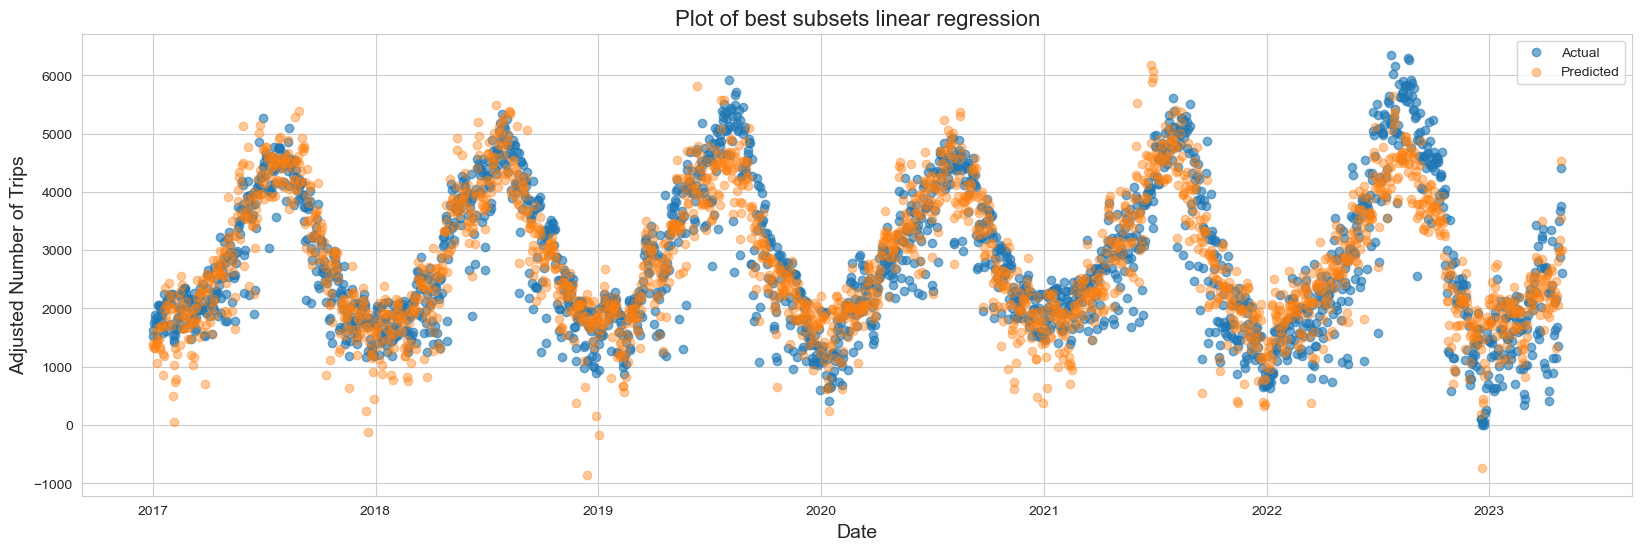

In [15]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.index,
           bikeshare[target],
           alpha=0.6,
           label='Actual')

reg_bestsubset = LinearRegression()
reg_bestsubset.fit(bikeshare_scaled[best_subset],
                   bikeshare[target])
preds_bestsubset = reg_bestsubset.predict(bikeshare_scaled[best_subset])

plt.scatter(bikeshare.index.values,
           preds_bestsubset,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression',fontsize=16)
plt.legend()

plt.show()

We can see that we have four main regions where the error is most apparent:
- The peak of summer 2019,
- The peak of summer 2022,
- COVID's outbreak, and
- Winter 2023.

Looking at the following plots below we can see that, comparatively to other years where our predictions look closer to the true values, the weather patterns in these pockets are not much different than those in other years. This suggests that our predictions' error is due to factors unrelated to the weather.

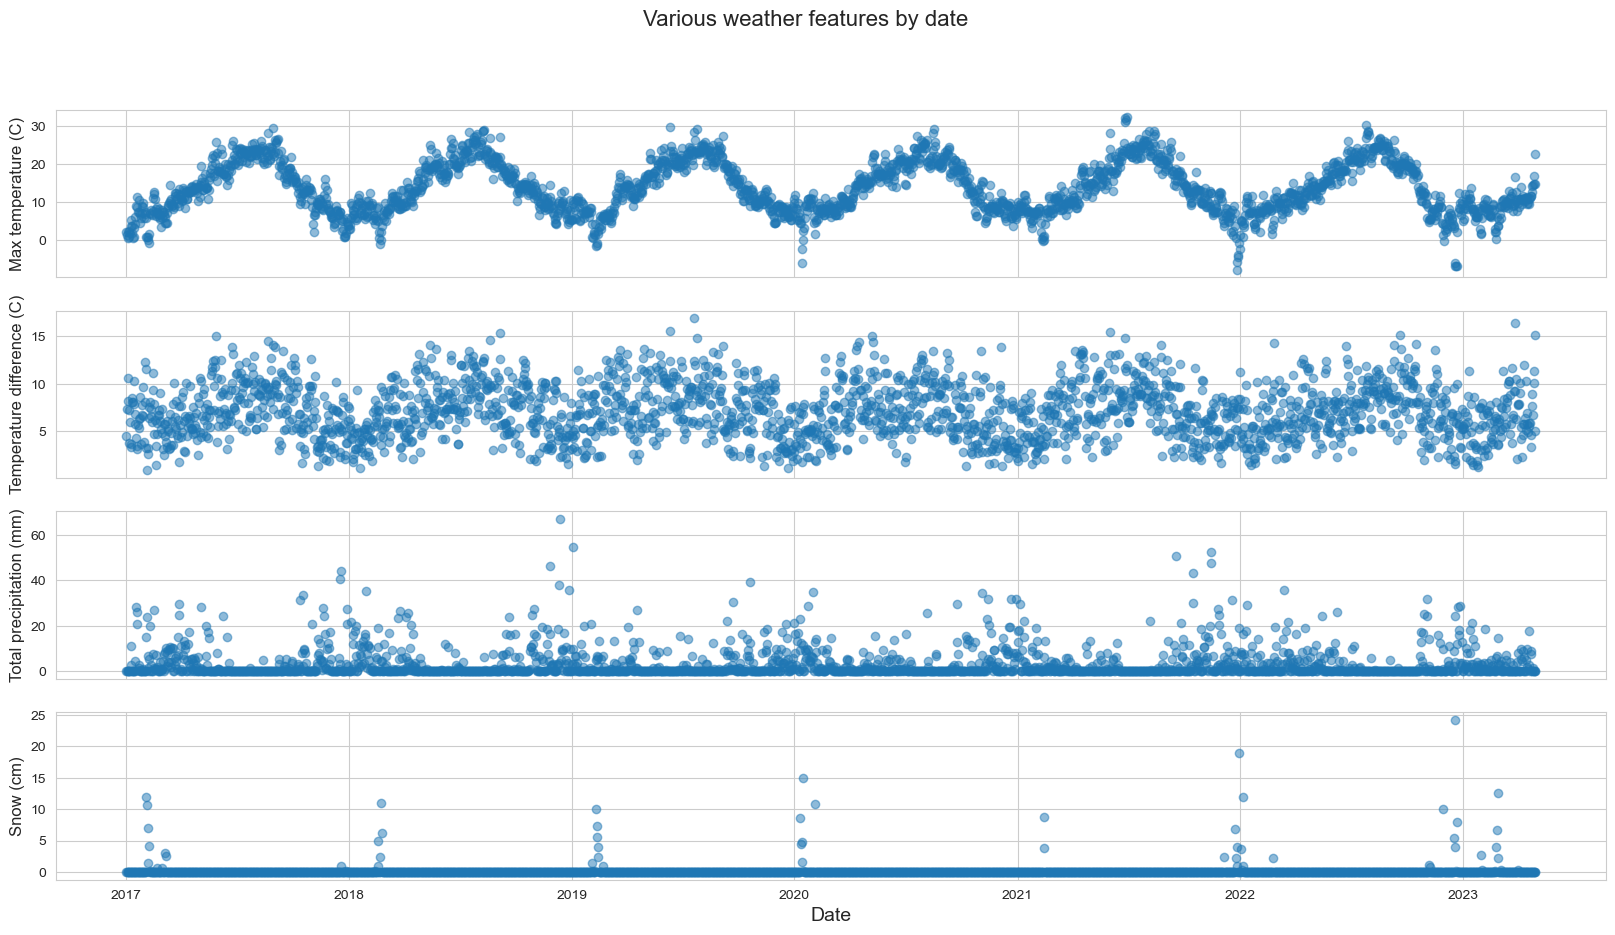

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex = True, figsize=(20,10))

plt.suptitle('Various weather features by date',fontsize=16)

ax[0].scatter(bikeshare.index,
           bikeshare.max_temp,
           alpha=0.5)
ax[0].set_ylabel('Max temperature (C)', fontsize=12)

ax[1].scatter(bikeshare.index,
           bikeshare.temp_diff,
           alpha=0.5)
ax[1].set_ylabel('Temperature difference (C)',fontsize=12)

ax[2].scatter(bikeshare.index,
           bikeshare.total_precip,
           alpha=0.5)
ax[2].set_ylabel('Total precipitation (mm)',fontsize=12)

ax[3].scatter(bikeshare.index,
           bikeshare.snow,
           alpha=0.5)
ax[3].set_ylabel('Snow (cm)',fontsize=12)

plt.xlabel('Date', fontsize=14)

plt.show()

Lastly a plot of residuals:

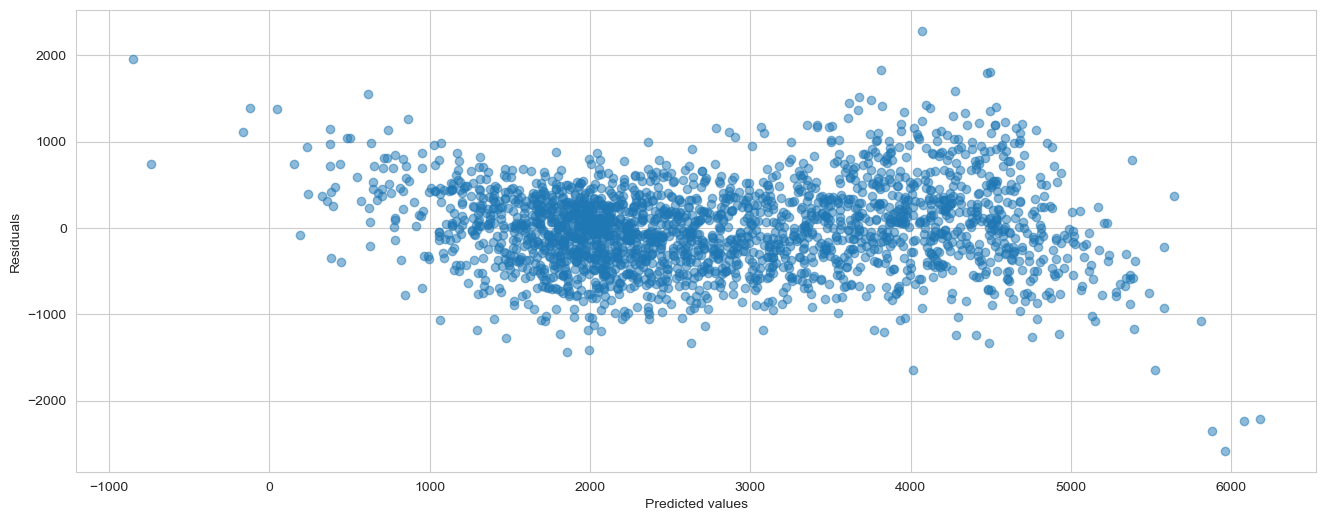

In [17]:
residuals = bikeshare[target] - preds_bestsubset

plt.figure(figsize=(16,6))

plt.scatter(preds_bestsubset,
           residuals,
           alpha=0.5)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.show()

While it doesn't quite look like we missed any significant signals or functional relationships (although it might be argued that this plot actually bears a resemblance to a reflection of the degree-3 polynomial base demand curve obtained in ``EDA.ipynb``) we can see that for higher predicted values the residuals have a larger range of possible values, although this is only exhibited by a few data points. Perhaps we might have been able to rectify this with a different weighting to the regression, but it also seems reasonable to say that this isn't too bad. 

# Performance on Test Data

First apply the transformations made in this notebook to the test data, and make a prediction for the target variable:

In [19]:
bikeshare_test_scaled = scaler.transform(bikeshare_test[features])
bikeshare_test_scaled[target] = bikeshare_test[target]

bikeshare_test_scaled['day_length_x_max_temp'] = bikeshare_test_scaled.day_length * bikeshare_test_scaled.max_temp

test_preds = reg_bestsubset.predict(bikeshare_test_scaled[best_subset])

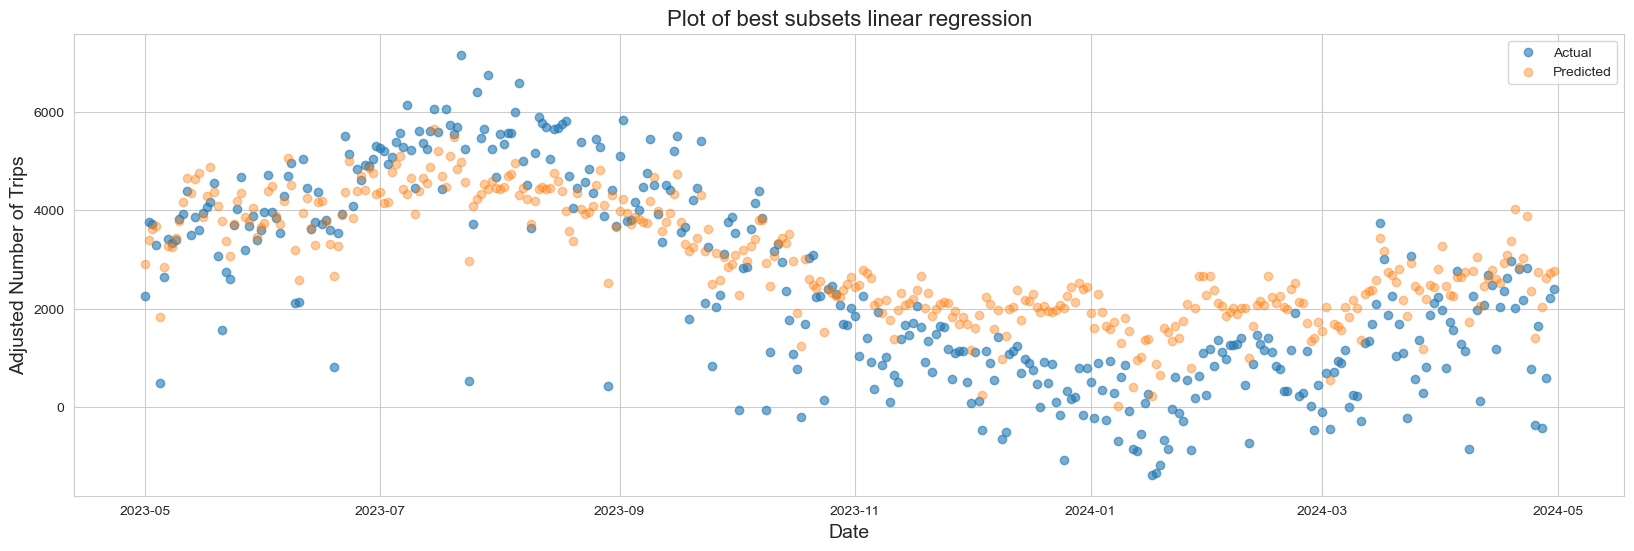

In [21]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare_test.index,
           bikeshare_test[target],
           alpha=0.6,
           label='Actual')

plt.scatter(bikeshare_test.index.values,
           test_preds,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression on test data',fontsize=16)
plt.legend()

plt.show()

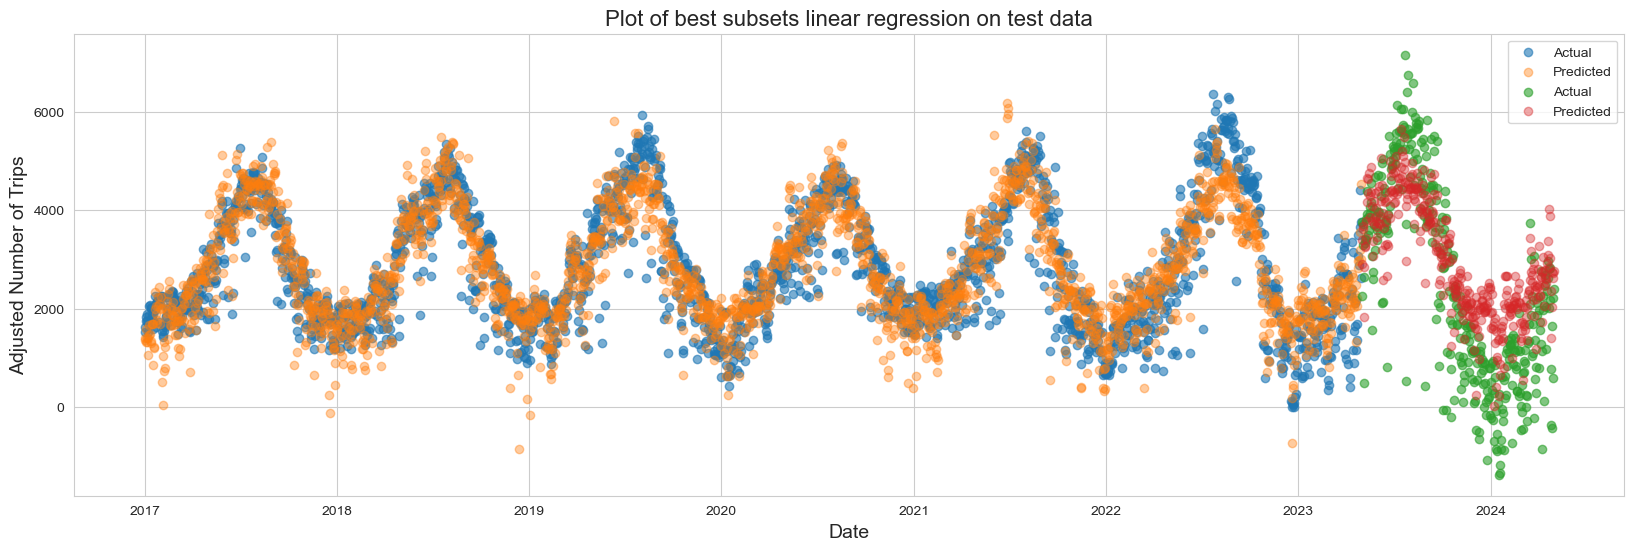

In [23]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.index,
           bikeshare[target],
           alpha=0.6,
           label='Actual')

plt.scatter(bikeshare.index.values,
           preds_bestsubset,
           alpha=0.4,
           label='Predicted')

plt.scatter(bikeshare_test.index,
           bikeshare_test[target],
           alpha=0.6,
           label='Actual')

plt.scatter(bikeshare_test.index.values,
           test_preds,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression on test data',fontsize=16)
plt.legend()

plt.show()

In [22]:
np.sqrt(mean_squared_error(bikeshare_test[target], test_preds))

1143.348795755457

We have quite a large difference between our training and test RMSEs. This normally might suggest overfitting, but in this case it actually just looks like our detrending is the issue since we make quite good predictions away from peak summer and peak winter in the test dates (and our detrending was supposed to accurately capture these peaks).